# Test attention

/home/jggomez/Desktop/Interspeech/interspeech-nlp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


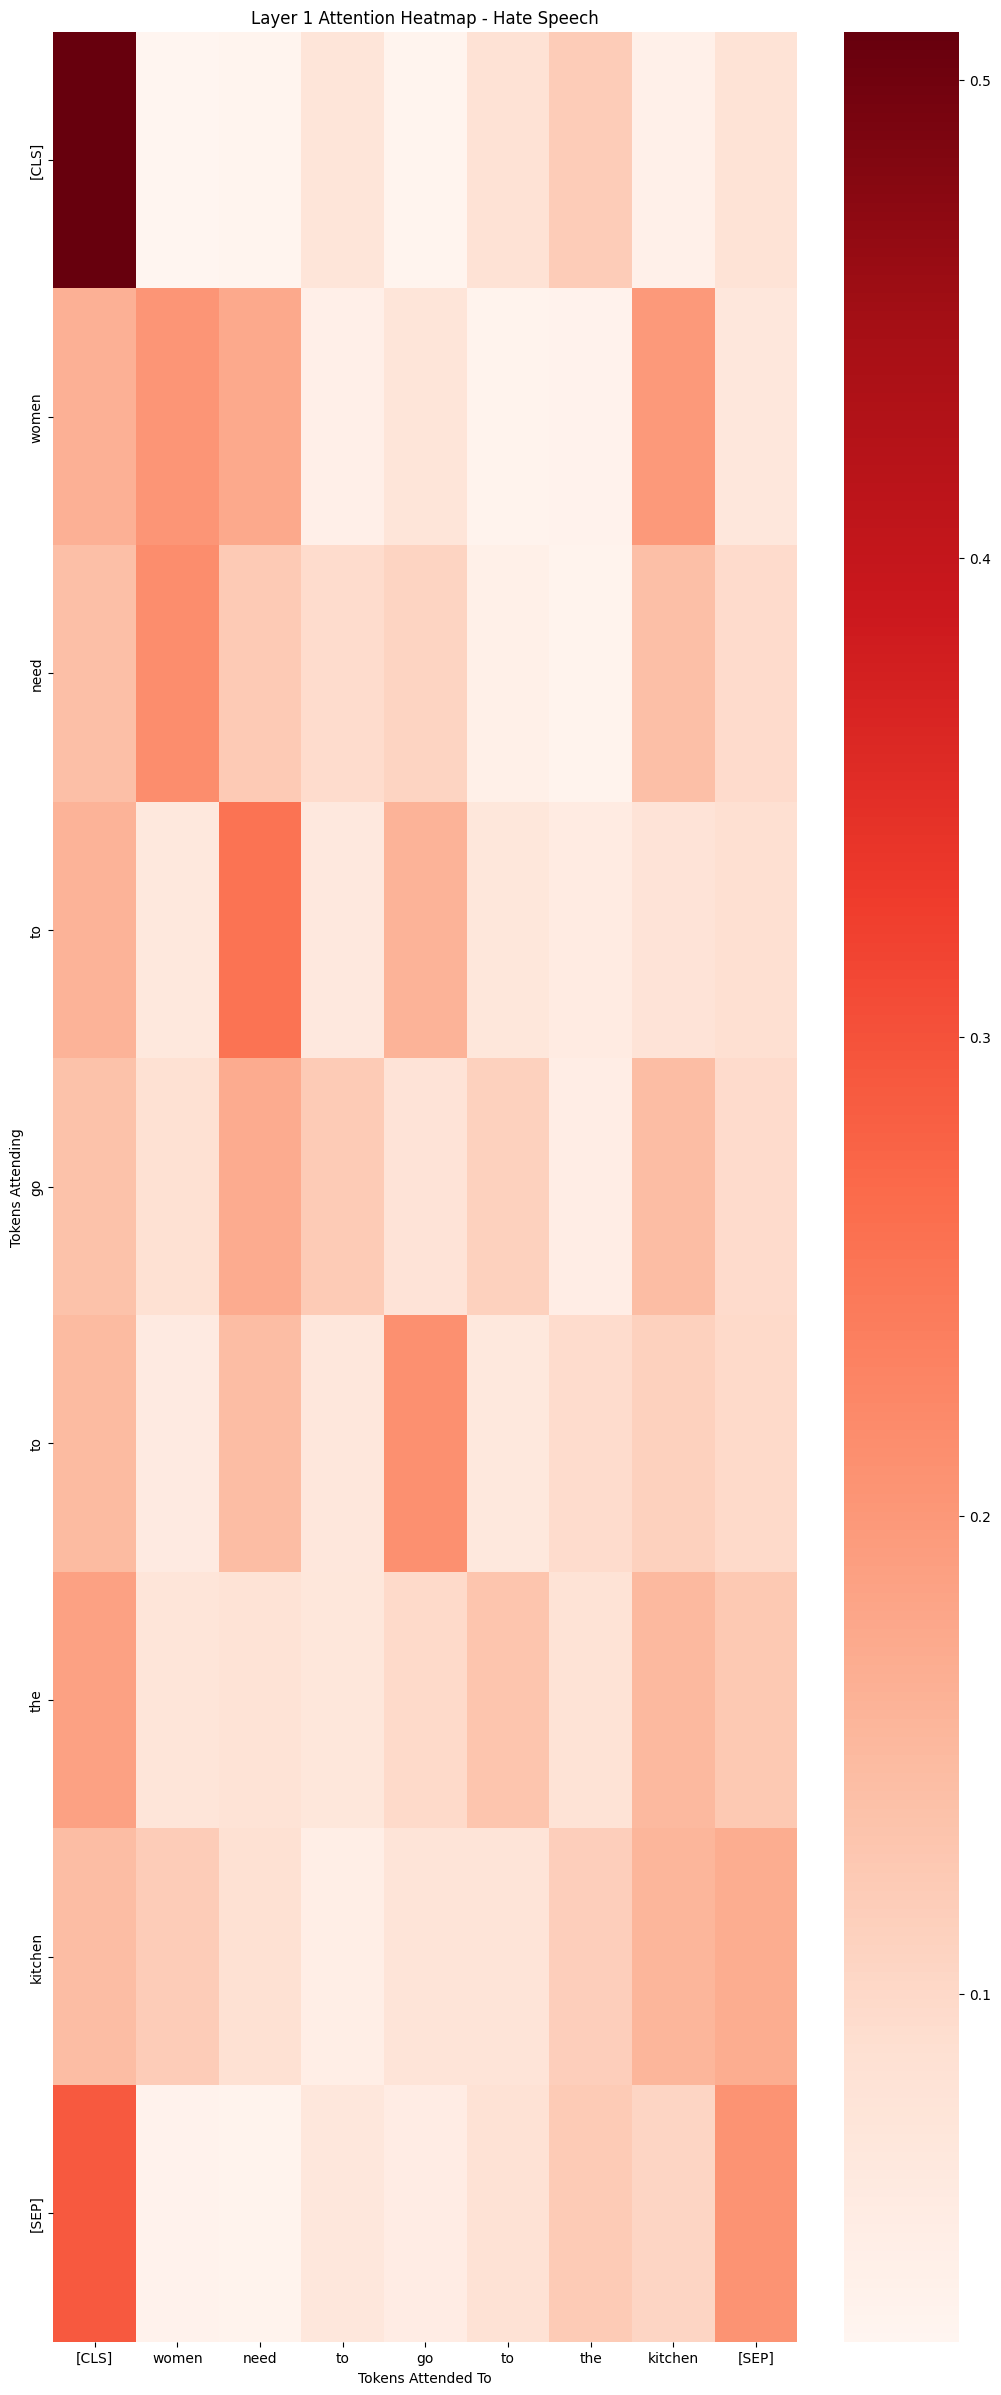

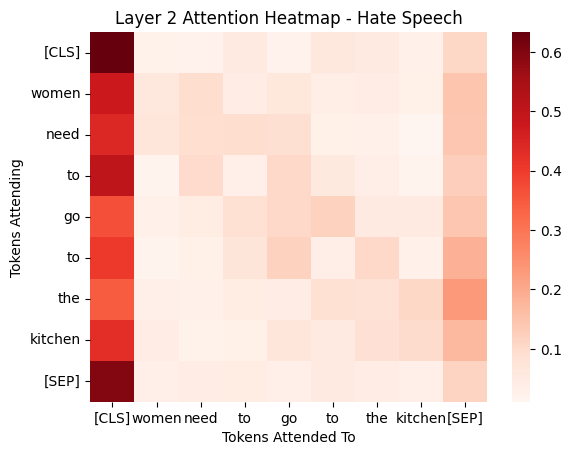

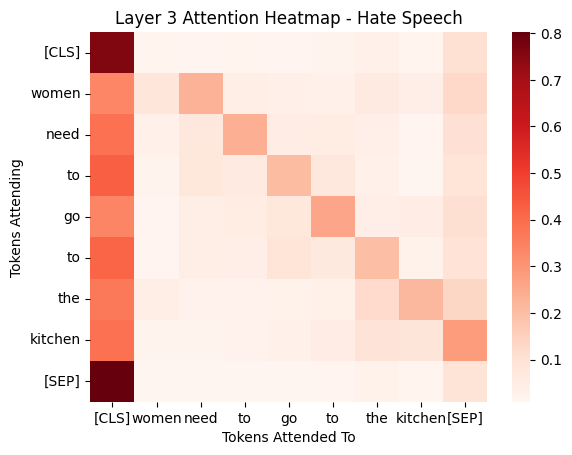

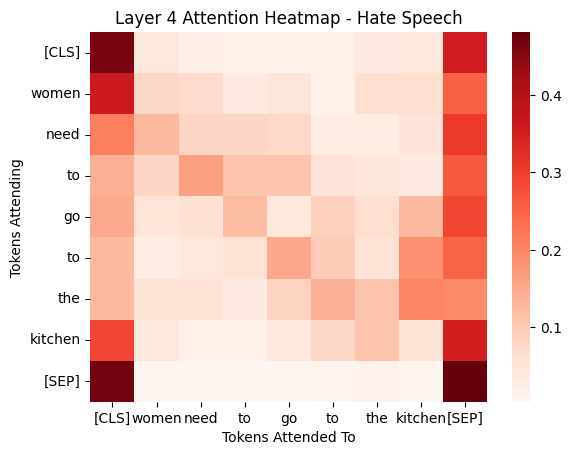

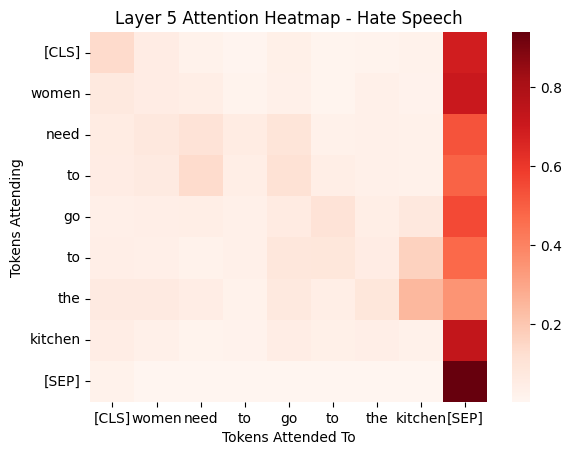

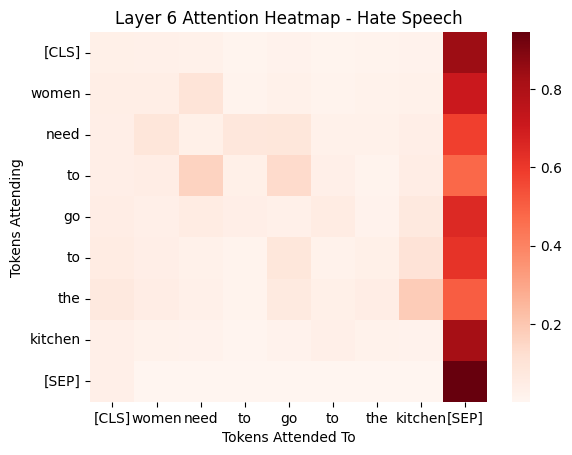

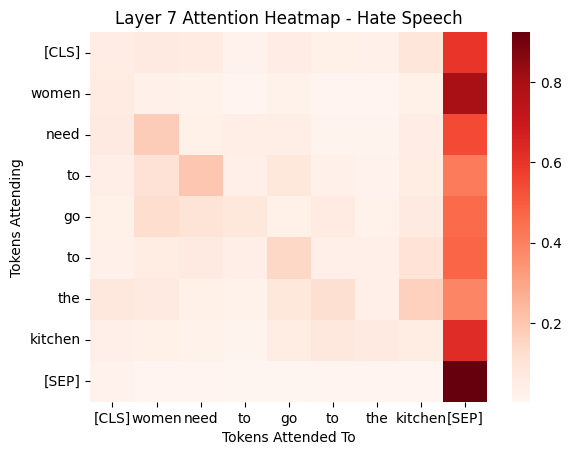

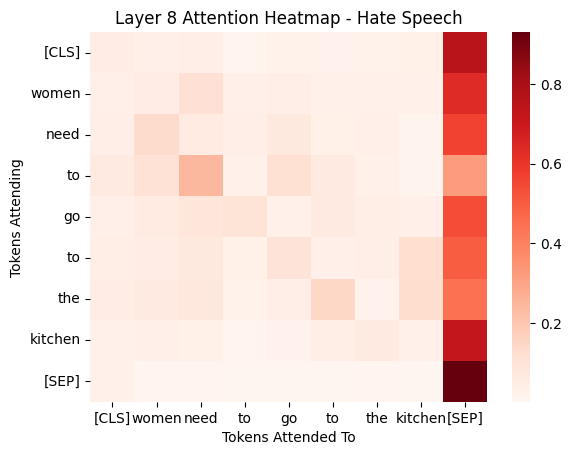

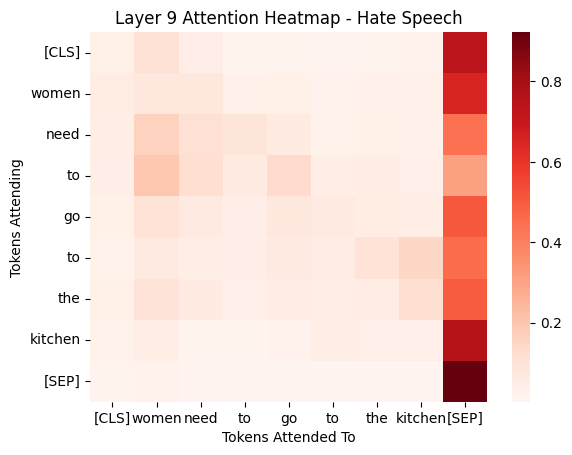

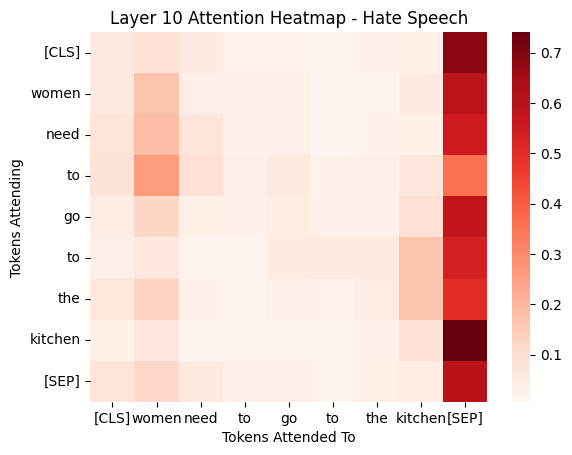

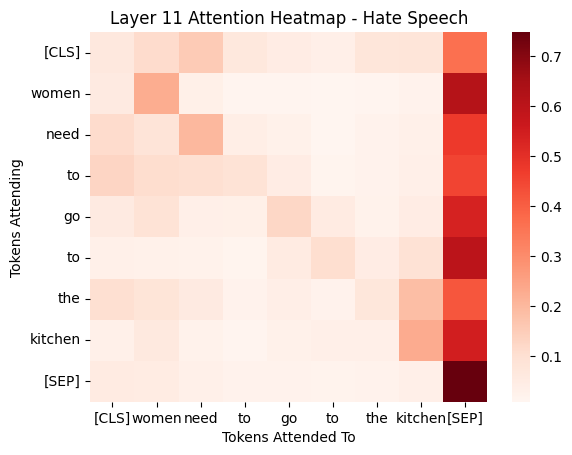

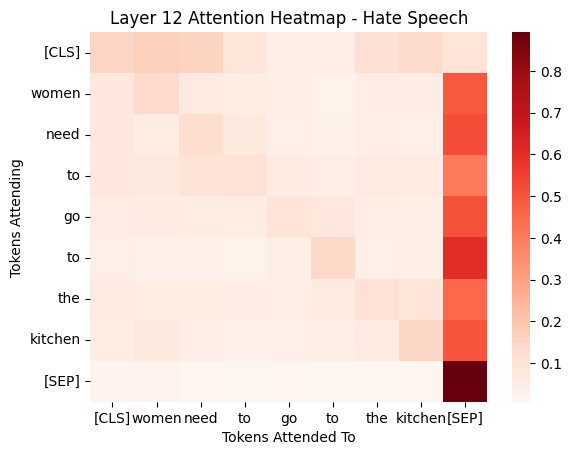

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargar el modelo preentrenado de detección de hate speech
model_name = "hate-speech-CNERG/bert-base-uncased-hatexplain"  # Modelo de ejemplo
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions=True)
model.eval()

# Frase de entrada
sentence = "women need to go to the kitchen"

# Tokenización e inferencia
inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
with torch.no_grad():
    outputs = model(**inputs)

# Obtener logits y atenciones
logits = outputs.logits
predicted_label = torch.argmax(logits, dim=-1).item()
all_attentions = outputs.attentions  # Atenciones de todas las capas

# Extraer tokens
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# Visualizar cada capa como un heatmap
plt.figure(figsize=(12, len(all_attentions) * 2.5))
for i, attention in enumerate(all_attentions):
    layer_attention = attention.mean(dim=1).squeeze(0).numpy()  # Promediar sobre los cabezales
    sns.heatmap(layer_attention, xticklabels=tokens, yticklabels=tokens, cmap="Reds", annot=False)
    plt.title(f"Layer {i + 1} Attention Heatmap - {'Hate Speech' if predicted_label == 1 else 'Non-Hate Speech'}")
    plt.xlabel("Tokens Attended To")
    plt.ylabel("Tokens Attending")
    plt.show()


🧐 ¿Cómo interpretar los heatmaps?

    Si una palabra tiene una fila con valores altos, significa que esa palabra está atendiendo a muchas otras palabras con gran peso.
    Si una columna tiene valores altos, significa que esa palabra está siendo atendida por otras.
    Capas bajas (1-6 en BERT) tienden a enfocarse en estructura gramatical.
    Capas medias-altas (7-12) tienden a capturar el significado y sesgos de hate speech.

-----------------------------------

In [8]:
import spacy
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForMaskedLM

# Cargar el modelo de spaCy para análisis de texto
nlp = spacy.load("en_core_web_sm")

# Cargar el modelo y tokenizer de BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForMaskedLM.from_pretrained("bert-base-uncased", output_attentions=True)

# ---- INPUT: Texto a analizar ----
text = "Women are naturally more emotional, while men are better leaders."

# ---- Paso 1: Análisis con spaCy ----
doc = nlp(text)
targets = []
arguments = []

for token in doc:
    if token.dep_ in ("nsubj", "nsubjpass"):  # TARGET: sujeto
        targets.append(token.text)
    elif token.dep_ in ("acomp", "attr", "advmod", "amod", "ccomp", "xcomp"):  # ARGUMENT: adjetivos, descripciones
        arguments.append(token.text)

print("Possible TARGETS (Subjects):", targets)
print("Possible ARGUMENTS (Bias indicators):", arguments)

# ---- Paso 2: Obtener atención de BERT ----
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs, output_attentions=True)
attentions = outputs.attentions[-1]  # Última capa de atención

# # Obtener la atención promedio sobre las cabezas
# att_weights = attentions.mean(dim=1).squeeze(0).mean(dim=0).detach().numpy()

# # Obtener los tokens procesados
# tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())

# # Filtrar puntuación y tokens especiales ([CLS], [SEP])
# valid_tokens = []
# valid_att_weights = []

# for token, weight in zip(tokens, att_weights):
#     if token not in [",", ".", "[CLS]", "[SEP]"]:
#         valid_tokens.append(token)
#         valid_att_weights.append(weight)

# # Normalizar atención
# valid_att_weights = np.array(valid_att_weights)
# valid_att_weights = valid_att_weights / valid_att_weights.sum()  # Normalizar suma a 1

# # ---- Visualización ----
# plt.figure(figsize=(10, 4))
# sns.heatmap([valid_att_weights], xticklabels=valid_tokens, cmap="Reds", annot=True, fmt=".2f")
# plt.title("Heatmap de Atención de BERT (sin puntuación)")
# plt.xlabel("Palabras")
# plt.ylabel("Atención")
# plt.xticks(rotation=45)
# plt.show()

# Obtener la atención media en todas las cabezas
att_weights = attentions.mean(dim=1).squeeze(0).detach().numpy()

# Si att_weights tiene 3 dimensiones, reducirlo a 2D (promediando cabezas de atención)
if att_weights.ndim == 3:  
    att_weights = att_weights.mean(axis=0)  # Ahora es (seq_len, seq_len)

# Obtener tokens
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())

# Encontrar índices de palabras clave
keywords = ["women", "men", "emotional", "leaders"]
indices = {word: tokens.index(word) for word in keywords if word in tokens}

# Verificar si todas las palabras están presentes antes de calcular la atención
if all(word in indices for word in ["women", "men", "emotional", "leaders"]):
    cross_attention = {
        "women → emotional": att_weights[indices["women"], indices["emotional"]],
        "men → leaders": att_weights[indices["men"], indices["leaders"]],
        "women → leaders": att_weights[indices["women"], indices["leaders"]],
        "men → emotional": att_weights[indices["men"], indices["emotional"]],
    }
    
    # Comparar relaciones
    print("Atención cruzada entre palabras clave:")
    print(cross_attention)
else:
    print("⚠️ No todas las palabras clave fueron encontradas en el tokenizado.")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Possible TARGETS (Subjects): ['Women', 'men']
Possible ARGUMENTS (Bias indicators): ['naturally', 'more', 'emotional', 'better', 'leaders']
Atención cruzada entre palabras clave:
{'women → emotional': np.float32(0.024970708), 'men → leaders': np.float32(0.029563306), 'women → leaders': np.float32(0.018828481), 'men → emotional': np.float32(0.017693058)}
